### Time Series Forecasting. Energy consumption prediction, notebook content 

### In this notebook the main goal is to work on a regression problem that aims to predict future values of energy consumption. A few other goals for this project is to: 

 * Compare different algorithems such as xgboost, facebook Prophet, RNN, LSTMS, ARIMA 
 * Build an end to end machine learning pipeline that is automated using MLflow to track, register and monitor specific requirements 
 * Research a useful implementation to this project wehther thats a flask app, a web app, a dashboard etc and what economic, social and environmental value can be gained from such a product
``

### The project will be iterative: MVP 1, 2,3, 4. Then automate the pipeline 

* Week 1 MVP 1
* Week 2 Iteration 2 (Model + some simple feature engineering)
* Week 3 Iteration 3 (Feature Engineering)
* Week 4 Iteration 3 pipline (pre processing, models, validation & loss)

* Weeks 5-8 Automation & Dashboard creation 


##### Minimal Viable Product 1 

* Loading the data (PJM Interconnection LLC regional trasmission organization in the united stated providing  )

* Feature Creation (very basic, from the time columns break down into different dates)

* Visualizing the time series (Exploratory Data Analysis)

* Train/Test split --> simple no cross validation
    * Everything prior to 2015 is training data 
    * Everything after 2015 is test data 

* Feature Importance 

* Forcast on test data 

* score (RMSE)

* Calculate Error 

In [74]:

# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb 

from sklearn.metrics import mean_squared_error
## Define a color palette
color_palette = sns.color_palette()
plt.rcParams['axes.grid'] = True


### Background Knowledge 

Reference 
https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

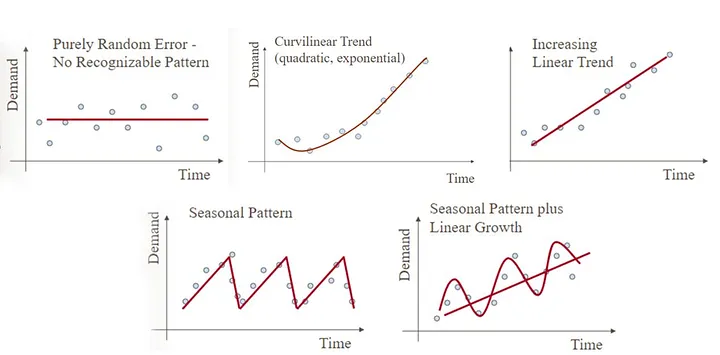


Most signals we analyze exhibit a comination of those patterns and hence can be "modelled" using the function 


Trend, Seasonality, Cyclic, and residual components 


U(t)  = T(t) + S(t) + C(t) + R(t)


In [75]:
## Read the data
df = pd.read_csv('PJME_hourly.csv')


In [76]:
## Quick Exploratory data analysis 
df.head(10)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
5,2002-12-31 06:00:00,26222.0
6,2002-12-31 07:00:00,28702.0
7,2002-12-31 08:00:00,30698.0
8,2002-12-31 09:00:00,31800.0
9,2002-12-31 10:00:00,32359.0


In [77]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [78]:
# Set the date as the index

df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [79]:
# Check type of index
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [80]:
#Change the index to datetime
df.index = pd.to_datetime(df.index)

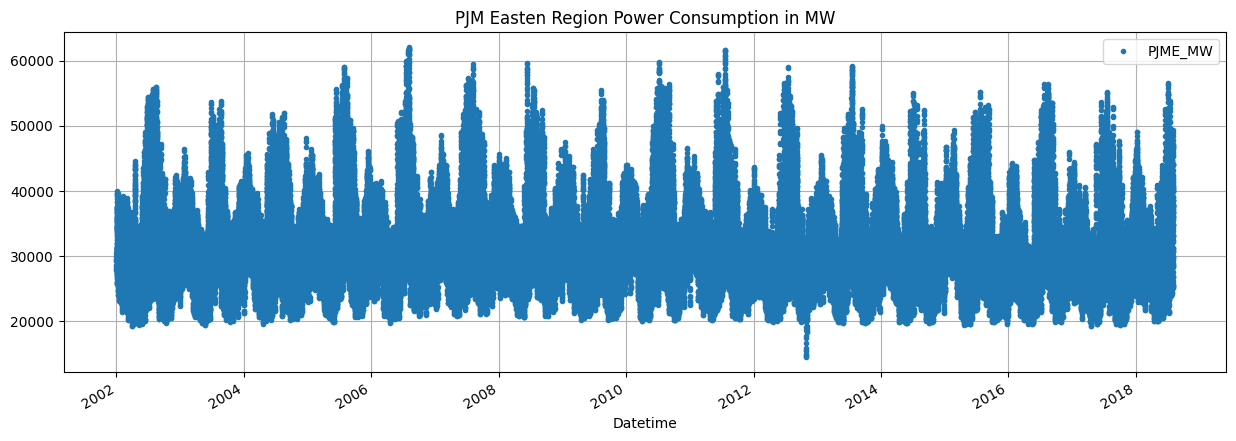

In [81]:
# Visualize the data 


# istantiate the figure
df.plot( style = '.',
         figsize = (15,5), 
         color = color_palette[0], 
         title = 'PJM Easten Region Power Consumption in MW')

# Plot the figure 
plt.show()


In [82]:
## Define Evaluation Metrics functions 

## Root mean square error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Mean absolute percentage error (MAPE)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Mean absolute error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))




### Train/Test split 

* Mvp 
* Model 1 

In [83]:
#Train test split 

# Everthing before 2015 is train data 

training_df = df.loc[df.index < '2015-01-01'] 
testing_df = df.loc[df.index >= '2015-01-01']


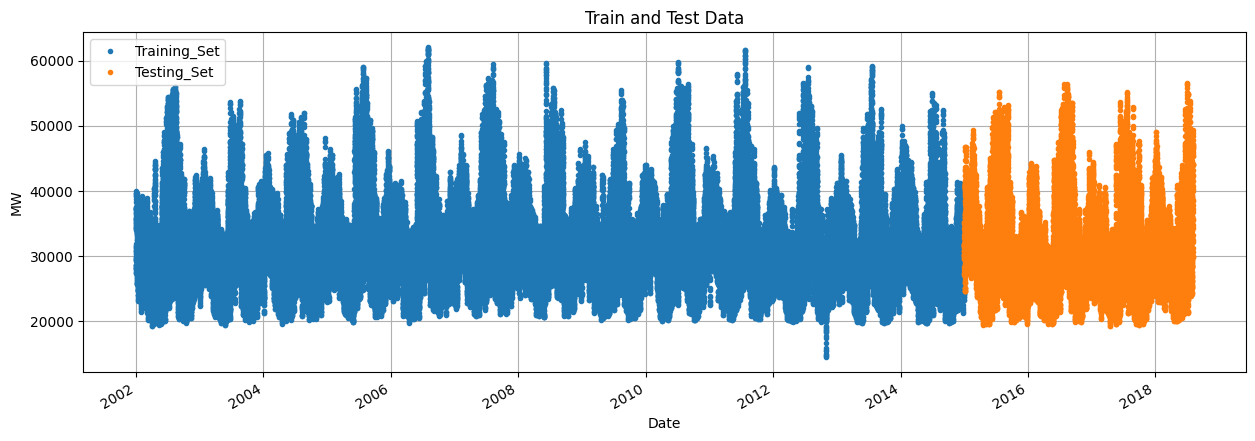

In [84]:
#Visualize the train and test data on the same plot to visulize the split using matplotlib subplots 

#Instantiate the figure
fig,ax = plt.subplots(figsize = (15,5))
training_df.plot(ax = ax, style = '.', label = 'Training_Set', color = color_palette[0])
testing_df.plot(ax = ax, style = '.', label = 'Testing_Set', color = color_palette[1])
ax.set_title('Train and Test Data')
ax.legend(['Training_Set','Testing_Set'])
plt.xlabel('Date')
plt.ylabel('MW')

#Plot the figure
plt.show()





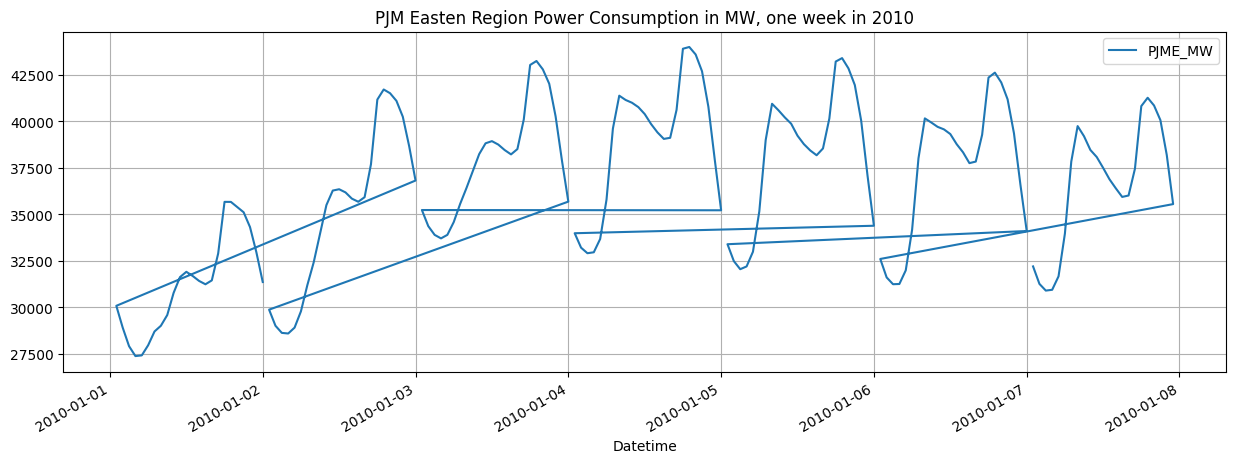

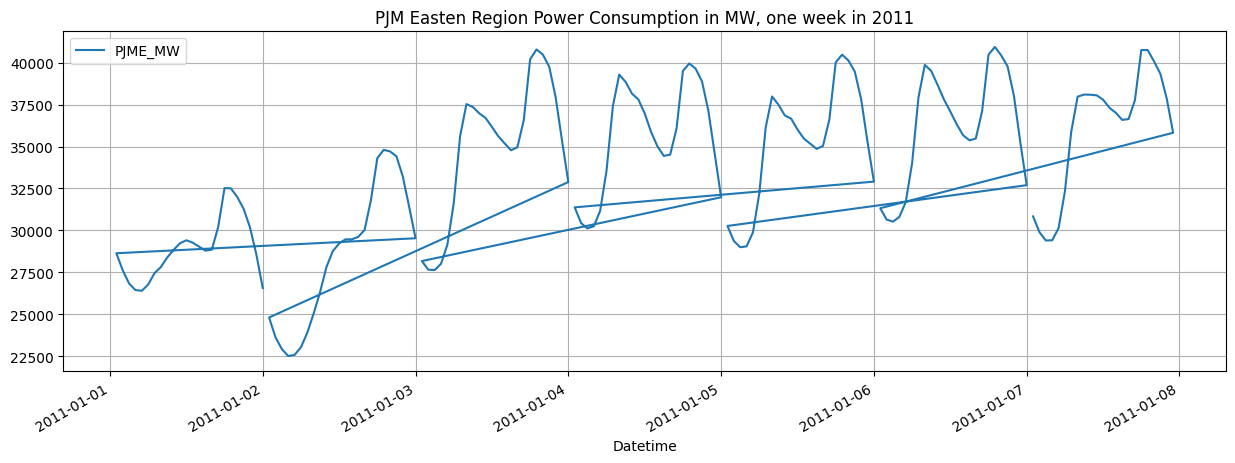

In [85]:
# Drill down on monthy and weekly data 

# January 2010 weekly

df_weekly = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] 
df_weekly.plot(
    
         figsize = (15,5), 
         color = color_palette[0], 
         title = 'PJM Easten Region Power Consumption in MW, one week in 2010')

# Plot the figure 


# January 2011 weekly 

df_weekly = df.loc[(df.index > '01-01-2011') & (df.index < '01-08-2011')]
df_weekly.plot(
    
         figsize = (15,5), 
         color = color_palette[0], 
         
         title = 'PJM Easten Region Power Consumption in MW, one week in 2011')

plt.show()


One can see from this weekly for 2010 and 2011 show similar behaviour in that it seems first and second of january are holidays and weekends so the overal energy consumption is lower but still varies up and down through the day as expected and as the rest of the week days 

## Feature creation 

Will create a function that takes in a dataframe, creates of few date features and returns this dataframe 

In [86]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


In [87]:
df = create_features(df)

In [88]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


Text(0.5, 1.0, 'Boxplot of Monthly Power Consumption by Month')

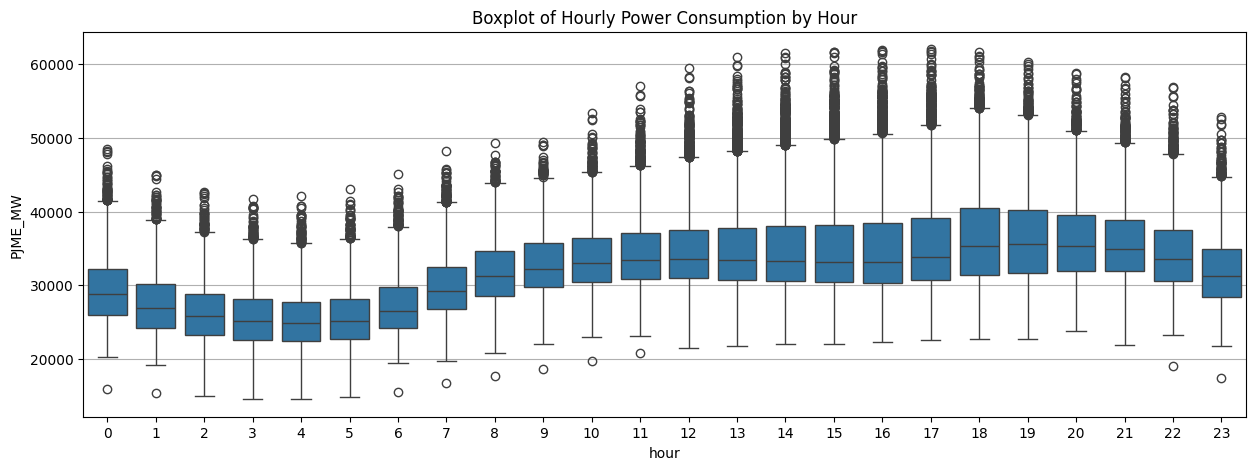

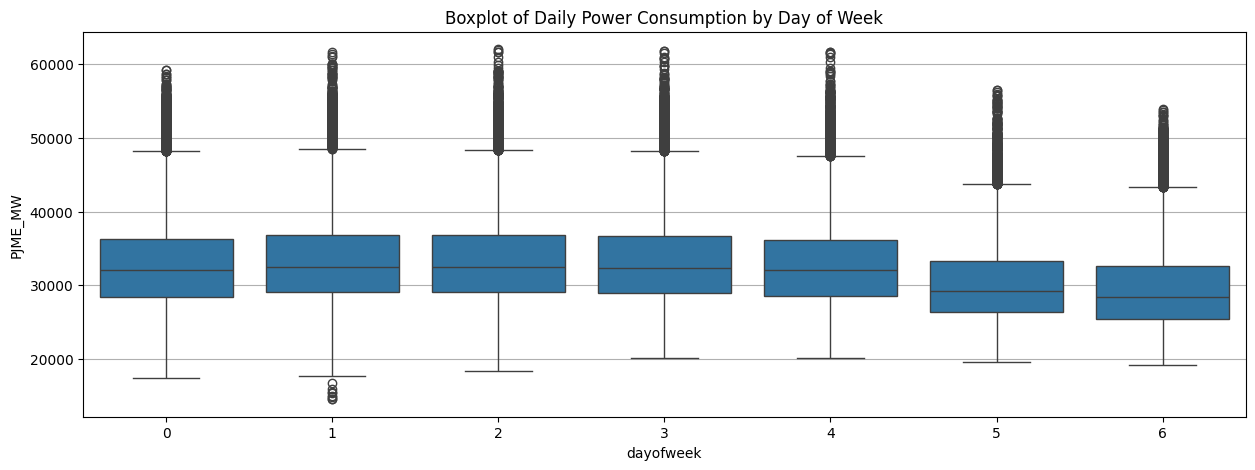

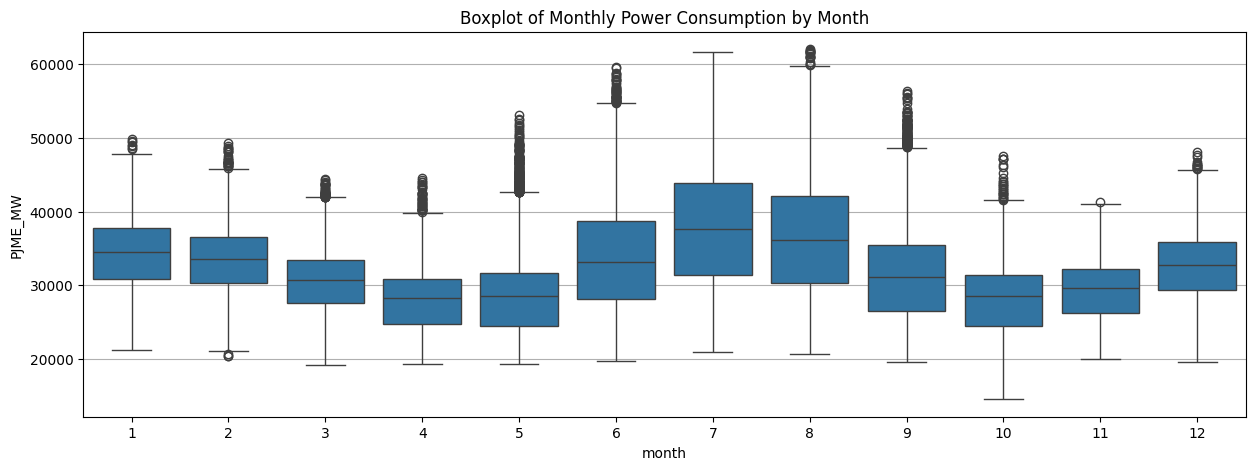

In [89]:
## Visualize feature to target relationship

## Hourly 
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df , x = 'hour', y = 'PJME_MW')
ax.set_title('Boxplot of Hourly Power Consumption by Hour')

## Daily
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df , x = 'dayofweek', y = 'PJME_MW')
ax.set_title('Boxplot of Daily Power Consumption by Day of Week')

## Monthly
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df , x = 'month', y = 'PJME_MW')
ax.set_title('Boxplot of Monthly Power Consumption by Month')




## Model 

In [90]:
## Add features to our train and test data

train = create_features(training_df) 
test = create_features(testing_df)


## Define the features and target columns 

features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = 'PJME_MW'



In [91]:
# Create X and y train

X_train = train[features]
y_train = train[target]

# Create X and y test

X_test = test[features]
y_test = test[target]

In [92]:
## Instantiate the model, fit and predict 
## Use early stopping to prevent overfitting

regression = xgb.XGBRegressor(n_estimators = 1000,  early_stopping_rounds = 50, learning_rate = 0.01)
regression.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 50)




[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619


[50]	validation_0-rmse:4762.32074	validation_1-rmse:5012.22041
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[150]	validation_0-rmse:3476.74522	validation_1-rmse:4012.03356
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[250]	validation_0-rmse:3096.08350	validation_1-rmse:3778.66977
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[350]	validation_0-rmse:2920.57462	validation_1-rmse:3742.00487
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [103]:
## Predict the test data
y_pred = regression.predict(X_test)

## Evaluate the model using all the evaluation metrics

print('RMSE:', rmse(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))

## Data frame of actual and predicted values

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head(10)


RMSE: 3741.030178837441
MAE: 2902.8865275375715
MAPE: 9.229212034214301


,Actual,Predicted
Datetime,,
2015-01-01 00:00:00,32802.0,32393.351562
2015-12-31 01:00:00,24305.0,29040.167969
2015-12-31 02:00:00,23156.0,27877.017578
2015-12-31 03:00:00,22514.0,27576.720703
2015-12-31 04:00:00,22330.0,27576.720703
2015-12-31 05:00:00,22773.0,27638.474609
2015-12-31 06:00:00,24106.0,29163.484375
2015-12-31 07:00:00,26129.0,32485.216797
2015-12-31 08:00:00,27660.0,33432.289062


## Feature Importances 

In [94]:
# Creating feature importance dataframe

feature_importance = pd.DataFrame(data = regression.feature_importances_, 
             index = regression.feature_names_in_, 
             columns = ['importance'])

In [95]:
feature_importance.head()

,importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824


<Axes: >

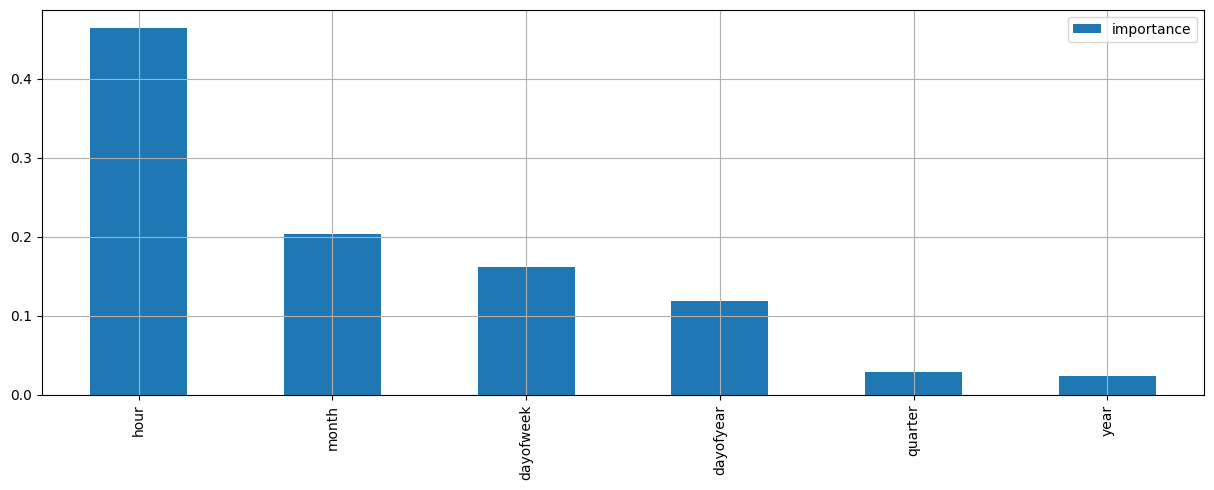

In [96]:
## Visualizing feature importance

feature_importance.sort_values(by = 'importance', ascending = False).plot(kind = 'bar', figsize = (15,5))

In [106]:
# ## Visualizing the prediction and the actual data

# fig, ax = plt.subplots(figsize = (15,5))
# ax.plot(test.index, y_test, label = 'Actual', color = color_palette[0])
# ax.plot(test.index, y_pred, label = 'Prediction', color = color_palette[1])
# ax.set_title('Actual vs Prediction')
# ax.legend(['Actual','Prediction'])
# plt.show()

# ## Merging the prediction with the raw data

df_f = df.merge(df_results['Predicted'],  how='left', left_index=True, right_index=True)
df_f

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Predicted
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,38623.246094
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,38495.484375
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,36229.527344


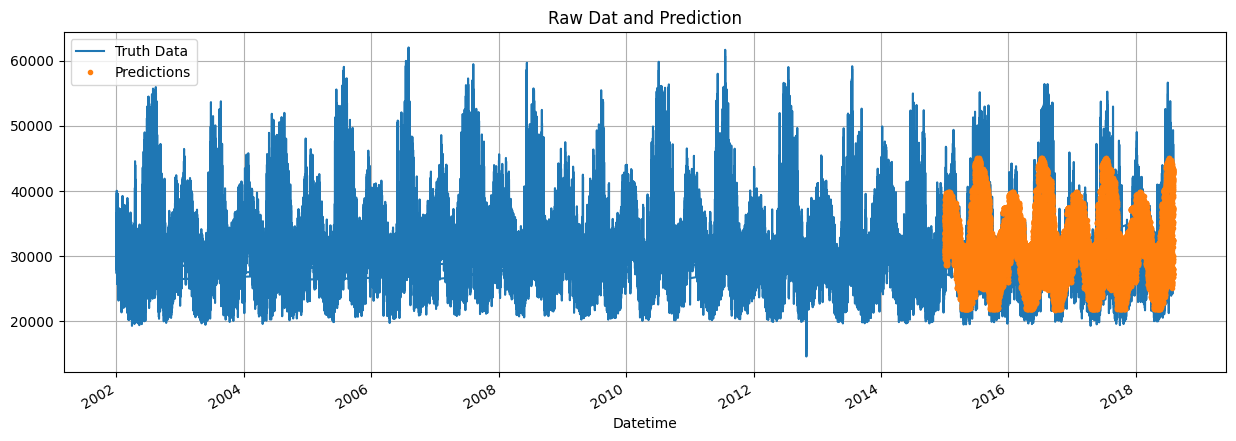

In [108]:
## Visualize the prediction and actual values

ax = df_f[['PJME_MW']].plot(figsize=(15, 5))
df_f['Predicted'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

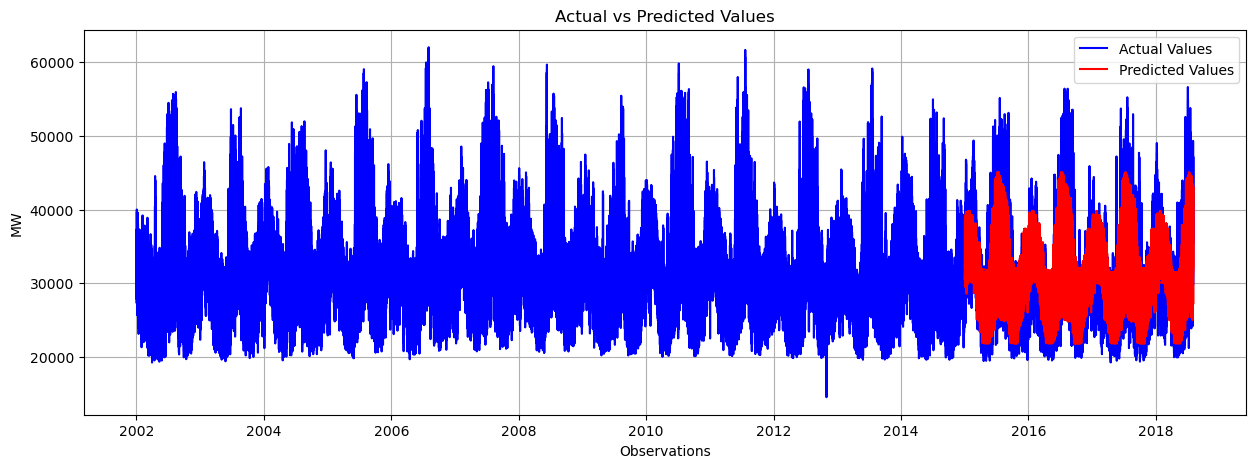

In [ ]:
## Visualize the prediction and actual values for the test data

actual_values = df_f[['PJME_MW']]
test["prediction"] = regression.predict(X_test)
predicted_values = test[['prediction']]


plt.figure(figsize = (15,5))

plt.plot(actual_values, color = 'blue', label = 'Actual Values')
plt.plot(predicted_values, color = 'red', label = 'Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('MW')
plt.legend()
plt.show()






In [ ]:
## Caclulate the RMSE

def calculate_rmse(actual_values, predicted_values):
    """
    Calculate Root Mean Squared Error (RMSE) between actual and predicted values.
    
    Parameters:
    - actual_values (numpy array or Pandas Series): Actual values.
    - predicted_values (numpy array or Pandas Series): Predicted values.
    
    Returns:
    - float: RMSE value.
    """
    rmse = np.sqrt(((actual_values - predicted_values) ** 2).mean())
    return rmse


## conver to numpy array

test[target] = test[target].to_numpy()
test['prediction'] = test['prediction'].to_numpy()




In [ ]:
# Calculate RMSE
rmse_value = calculate_rmse(test[target], test['prediction'])

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse_value}")

Root Mean Squared Error (RMSE): 3741.030178837441


## Iteration two 

* Loading the data (PJM Interconnection LLC regional trasmission organization in the united stated providing)

* Feature Creation (lag features) 

* Visualizing the time series (Exploratory Data Analysis)

* Train/Test split --> simple no cross validation
    * Everything prior to 2015 is training data 
    * Everything after 2015 is test data 

* Feature Importance 

* Forcast on test data 

* score (RMSE)

* Calculate Error 

#### Data Cleaning and Outlier Detection 

In [109]:
# Data cleaning and outlier detection

df['PJME_MW'].describe()

count    145366.000000
mean      32080.222831
std        6464.012166
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64

Looks like data is right skewed a little bit, there also spikes high above third std in both directions those could be outliers that need removing to help the algorithm train better. 

<Axes: ylabel='Frequency'>

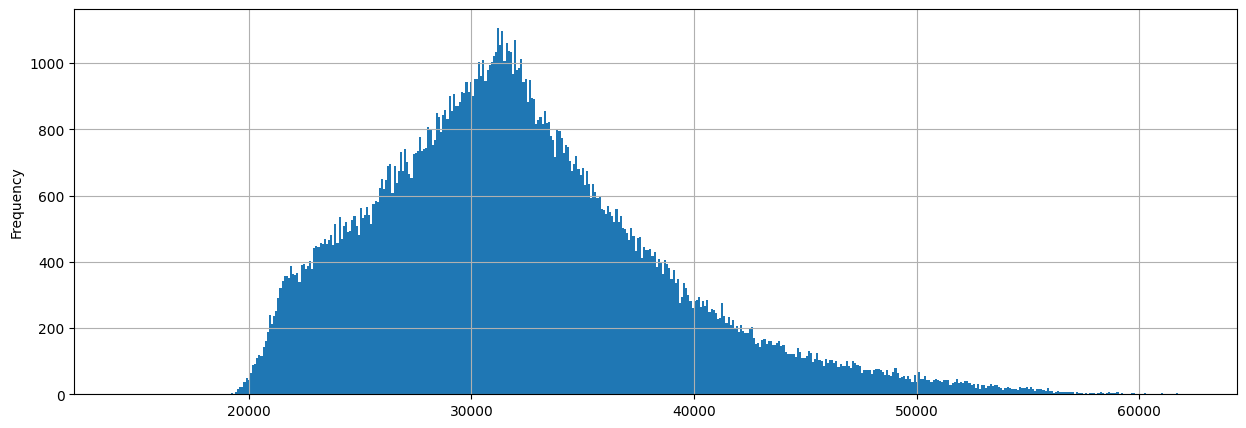

In [110]:
df['PJME_MW'].plot(kind = 'hist', bins=500, figsize = (15,5))

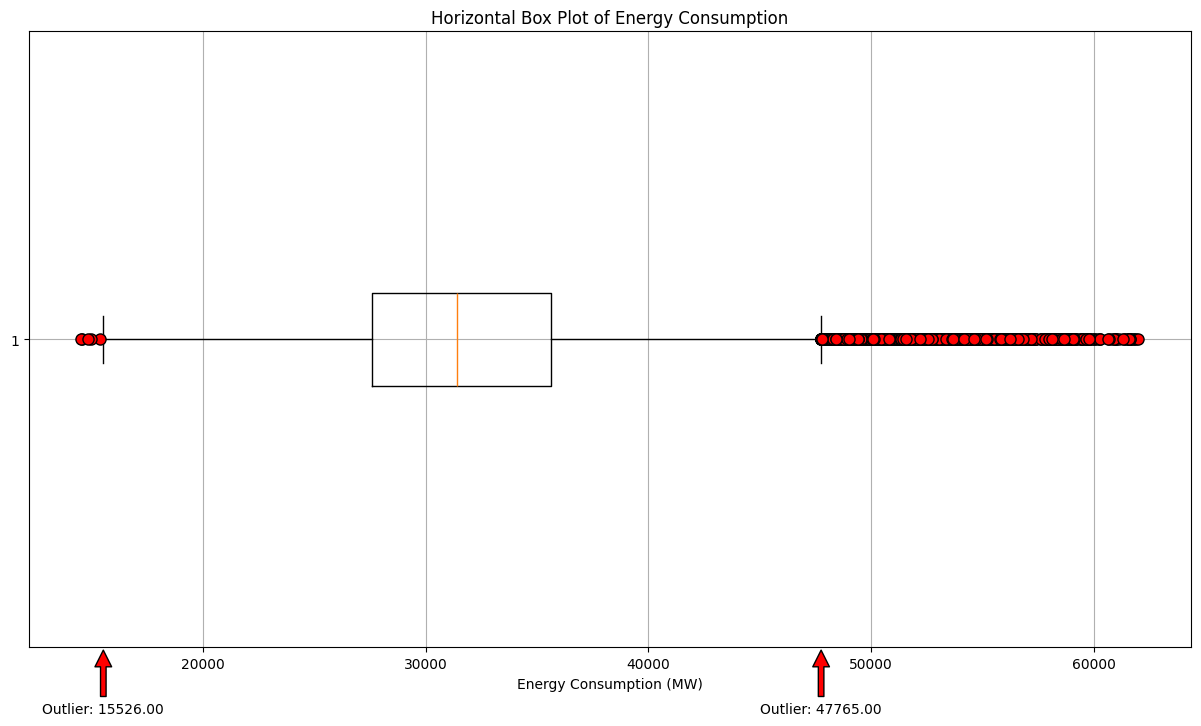

In [111]:
## 

# Assuming df is your DataFrame with the 'PJME_MW' column
data = df['PJME_MW']

# Create a larger horizontal box plot
plt.figure(figsize=(15, 8))
boxplot = plt.boxplot(data, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))

# You can also set additional properties like labels and title if needed
plt.xlabel('Energy Consumption (MW)')
plt.title('Horizontal Box Plot of Energy Consumption')

# Extract the x-values of the left and right whiskers
whisker_left = boxplot['whiskers'][0].get_xdata()
whisker_right = boxplot['whiskers'][1].get_xdata()

# Mark the position of the ends of both whiskers on the plot
plt.annotate(f'Outlier: {whisker_left[1]:.2f}', xy=(whisker_left[1], 0.5), xytext=(whisker_left[1], 0.4),
             arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='center')

plt.annotate(f'Outlier: {whisker_right[1]:.2f}', xy=(whisker_right[1], 0.5), xytext=(whisker_right[1], 0.4),
             arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='center')

# Show the plot
plt.show()



In [112]:
## Remove outliers and make a copy of the dataframe

df1 = df.copy()
## Keep values between 15000 and 60000
df1 = df1[df1['PJME_MW'] > 15000]
df1 = df1[df1['PJME_MW'] < 60000]

In [113]:
df1.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


#### Time Series Cross Validation 

Time series split cross validation sklearn documentation 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html



In [114]:
## Time series cross validation 
## Import sklearn time series split

from sklearn.model_selection import TimeSeriesSplit

## Define the number of splits
n_splits = 5
## define the test size (24 hours, 365 days, 1 year prediction into the future)
test_size = 24*365*1 

## define gap 
gap = 24

## Instantiate the time series split
tss = TimeSeriesSplit(n_splits = n_splits, test_size = test_size, gap = gap)
df1 = df1.sort_index()


So the timetestsplit object is a generator, so to train on this you have to loop your dataset over it. 

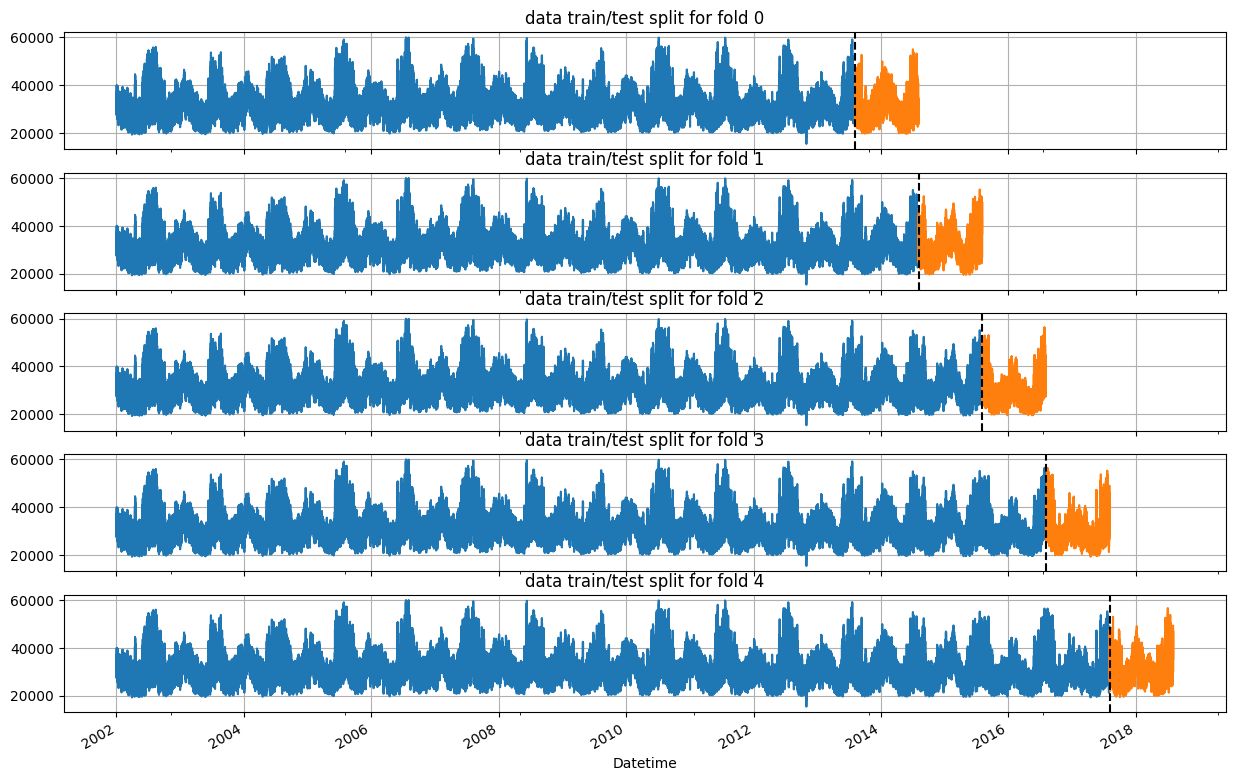

In [115]:
## Visualize the splits 

fig, ax = plt.subplots(5, 1, figsize = (15,10), sharex = True)


## Track each fold 


fold = 0 
for train_index, test_index in tss.split(df1):
    # Define train and test for each fold
    train = df1.iloc[train_index]
    test = df1.iloc[test_index]
    # Plot train and test
    train['PJME_MW'].plot(ax = ax[fold], color = color_palette[0], label = 'Training data', title = f'data train/test split for fold {fold}')
    test['PJME_MW'].plot(ax = ax[fold], color = color_palette[1], label = 'Testing data')
    # Vertical line to separate train from test
    ax[fold].axvline(test.index.min(), color = 'black', linestyle = '--')
    # Iterate fold
    fold += 1

plt.show()




#### Feature Creation 

1. Lag Features

In [116]:
## Creating lag feature and feeding it to the model

## defining a function to create lag features 

def create_lag_features(df):

    target_map = df['PJME_MW'].to_dict()
    df['lag_1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df



In [117]:
## Create lag feature for dataframe

df2 = create_lag_features(df1)


In [ ]:
df2.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1,lag_2,lag_3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


In [ ]:
df2.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1,lag_2,lag_3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


#### Training the model

* Cross validation folds 
* Lag features 

In [118]:
## Training the model with lag features and time series cross validation

## Define the number of splits
n_splits = 5
## define the test size (24 hours, 365 days, 1 year prediction into the future)
test_size = 24*365*1 
## define gap 
gap = 24
## Instantiate the time series split
tss = TimeSeriesSplit(n_splits = n_splits, test_size = test_size, gap = gap)
df1 = df1.sort_index()

fold = 0 
predictions = []
scores = []
for train_index, test_index in tss.split(df1):
    # Define train and test for each fold
    train = df1.iloc[train_index]
    test = df1.iloc[test_index]

    ## Add features to our train and test data
    train = create_features(train) 
    test = create_features(test)


    ## Define the features and target columns 
    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1', 'lag_2', 'lag_3']
    target = 'PJME_MW'


    # Create X and y train
    X_train = train[features]
    y_train = train[target]

    # Create X and y test
    X_test = test[features]
    y_test = test[target]


    ## Instantiate the model, fit and predict


    regression = xgb.XGBRegressor(n_estimators = 1000,  early_stopping_rounds = 50, learning_rate = 0.01, max_depth = 10, objective = 'reg:squarederror') 
    regression.fit(X_train, y_train, 
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose = 100)




    y_predict = regression.predict(X_test)
    predictions.append(y_predict)
    score = np.sqrt(mean_squared_error(y_test, y_predict))
    scores.append(score)
    print(f"Fold {fold}: RMSE: {score}")
    fold += 1




[0]	validation_0-rmse:6430.12900	validation_1-rmse:6137.20342
[100]	validation_0-rmse:3417.87494	validation_1-rmse:3997.62069
[200]	validation_0-rmse:2425.72281	validation_1-rmse:3767.96427
[287]	validation_0-rmse:2078.24069	validation_1-rmse:3773.46213
Fold 0: RMSE: 3760.8596988293325
[0]	validation_0-rmse:6407.13411	validation_1-rmse:6245.12927
[100]	validation_0-rmse:3452.47395	validation_1-rmse:3971.71797
[200]	validation_0-rmse:2518.37446	validation_1-rmse:3541.76912
[300]	validation_0-rmse:2132.20676	validation_1-rmse:3478.52760
[400]	validation_0-rmse:1899.59024	validation_1-rmse:3449.44962
[488]	validation_0-rmse:1743.95126	validation_1-rmse:3453.18060
Fold 1: RMSE: 3446.1121751964447
[0]	validation_0-rmse:6393.96562	validation_1-rmse:6601.75265
[100]	validation_0-rmse:3474.14509	validation_1-rmse:4278.58690
[200]	validation_0-rmse:2543.27767	validation_1-rmse:3850.69182
[261]	validation_0-rmse:2296.95271	validation_1-rmse:3849.47744
Fold 2: RMSE: 3843.7605816367645
[0]	validat

In [119]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3812.8132
Fold scores:[3760.8596988293325, 3446.1121751964447, 3843.7605816367645, 4022.6318393778774, 3990.7017010382783]


In [120]:
## Predict the test data
y_pred = regression.predict(X_test)

## Evaluate the model using all the evaluation metrics

print('RMSE:', rmse(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))



RMSE: 3990.7017010382783
MAE: 2976.5884509221605
MAPE: 9.438707299598649


## Iteration two 

* Loading the data (PJM Interconnection LLC regional trasmission organization in the united stated providing)
* Facebook Prophet (Additive regressive model) y(t) = g(t) + h(t) + s(t) + et (Trend Factor, Holiday component, Seasonality component, )
* Holidays 

* RNN model 
* LSTM model 





In [122]:
## Using facebook prophet to predict the time series

## Import prophet
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')



/Users/marwan/miniforge3/envs/Time_Series/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [137]:
## Create a copy of the dataframe

df3 = df.copy()
df3.head()


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


In [138]:
## Remove all features from dataframe except date and target 

df3 = df3[['PJME_MW']]
df3.head()

## Check date type
df3.index


DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [139]:
## Create a function for facebook prophet df 
def create_features_prophet(df):
    df.reset_index(inplace=True)
    df.rename(columns={'Datetime':'ds','PJME_MW':'y'}, inplace=True)
    return df

## Pass df3 throught the function
df_prophet = create_features_prophet(df3)

In [140]:
df_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [141]:
## Train the model on the cross validation data


## Define the number of splits
n_splits = 5
## define the test size (24 hours, 365 days, 1 year prediction into the future)
test_size = 24*365*1 
## define gap 
gap = 24
## Instantiate the time series split
tss = TimeSeriesSplit(n_splits = n_splits, test_size = test_size, gap = gap)
df_prophet = df_prophet.sort_index()


df_prophet.head()



,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
## Training the model with cross validation

fold = 0
predictions = []
scores = []

for train_index, test_index in tss.split(df_prophet):
    # Define train and test for each fold
    train = df_prophet.iloc[train_index]
    test = df_prophet.iloc[test_index]

    ## Instantiate the model, fit and predict
    model = Prophet()
    model.fit(train)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=len(test), freq='H')

    forecast = model.predict(future)

    # Extract the prediction
    y_predict = forecast.iloc[-len(test):]['yhat'].values
    predictions.append(y_predict)
    
    ## Calculate the RMSE
    score = np.sqrt(mean_squared_error(test['y'], y_predict))
    scores.append(score)
    print(f"Fold {fold}: RMSE: {score}")
    fold += 1


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 7720.3614
Fold scores:[7465.264537982854, 8551.057141932357, 9232.244417194892, 7736.099595122755, 5617.1415139028895]


In [ ]:
df_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
## Predict test data using prophet model 
y_pred = model.predict(test)

## Evaluate the model using all the evaluation metrics

print('RMSE:', rmse(test['y'], y_pred))
print('MAE:', mae(test['y'], y_pred))
print('MAPE:', mape(test['y'], y_pred))


#### Adding US holidays to the model to try and improve its predictive power 

In [ ]:
# ## Add US holidays to the model 

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

holidays = cal.holidays(start=df_prophet['ds'].min(), end=df_prophet['ds'].max())

## Create a holiday dataframe to pass to the model
holiday_df = pd.DataFrame(data = holidays, columns = ['ds'])



In [ ]:
holiday_df.head()

,ds
0,2002-01-21
1,2002-02-18
2,2002-05-27
3,2002-07-04
4,2002-09-02


In [ ]:
## Train the model with holidays

## Define the number of splits
n_splits = 5
## define the test size (24 hours, 365 days, 1 year prediction into the future)
test_size = 24*365*1 
## define gap 
gap = 24
## Instantiate the time series split
tss = TimeSeriesSplit(n_splits = n_splits, test_size = test_size, gap = gap)
df_prophet = df_prophet.sort_index()

fold = 0 
predictions = []
scores = []

for train_index, test_index in tss.split(df_prophet):
    # Define train and test for each fold
    train = df_prophet.iloc[train_index]
    test = df_prophet.iloc[test_index]

    ## Instantiate the model, fit and predict
    model = Prophet(holidays = holiday_df)
    model.fit(train)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=len(test), freq='H')
    forecast = model.predict(future)


    # Extract the prediction
    y_predict = forecast.iloc[-len(test):]['yhat'].values
    predictions.append(y_predict)
    score = np.sqrt(mean_squared_error(test['y'], y_predict))
    scores.append(score)
    print(f"Fold {fold}: RMSE: {score}")
    fold += 1



In [ ]:
## Predict test data using prophet model
y_pred = model.predict(test)

## Evaluate the model using all the evaluation metrics

print('RMSE:', rmse(test['y'], y_pred))
print('MAE:', mae(test['y'], y_pred))
print('MAPE:', mape(test['y'], y_pred))


ModuleNotFoundError: No module named 'meteostat'

## RNN Model 



In [143]:
## RNN model with 30 days lookback and 1 day prediction 
## The train will have a threshold of 0.75 which is 12 years from 2002 to 2014, the rest will be test data
## The model will be trained on the training data and tested on the test data


In [144]:
## RNN model libraries imports 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split    # Import train_test_split function


In [145]:
## Read the data
df_RNN = pd.read_csv('PJME_hourly.csv')
df_RNN.head()

## Set the date as the index
df_RNN = df_RNN.set_index('Datetime')
## Change the index to datetime
df_RNN.index = pd.to_datetime(df_RNN.index)

In [146]:
## Reshape the data to 1 column
Rnn_input = df_RNN.values.reshape(-1, 1)
print(len(Rnn_input))

145366


In [147]:
## Scale the data

scaler = MinMaxScaler(feature_range=(0, 1))
Rnn_input = scaler.fit_transform(Rnn_input)
print(len(Rnn_input))
print(Rnn_input.shape)

145366
(145366, 1)


In [148]:
## Creating the x and y data. 30 values to predict the next 1 day 
# x = RNN_Input[0:10]
# Y = RNN_Input[10]
# print(x)
# print(f"y = {y}")
# x1 = RNN_Input[1:11]
# Y1 = RNN_Input[11]
# print(x1)
# print(f"y1 = {Y1}")

In [149]:
## Creating x and y for the RNN model


look_back = 30 

X = []
Y = []

for i in range(Rnn_input.shape[0] - look_back):
    X.append(Rnn_input[i:i+look_back])
    Y.append(Rnn_input[i+look_back])

## Print the x and y shapes 
print(np.shape(X))
print(np.shape(Y))

(145336, 30, 1)
(145336, 1)


In [150]:
## X and Y data
X = np.array(X)
Y = np.array(Y)
print(np.shape(X))
print(np.shape(Y))

threshold = round(0.75 * X.shape[0])
print('Threshold is', threshold)

(145336, 30, 1)
(145336, 1)
Threshold is 109002


In [151]:
## X train and test data

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)
x_train, y_train = X[:threshold], Y[:threshold]
x_test, y_test = X[threshold:], Y[threshold:]
print("Train Shape is", x_train.shape, y_train.shape)
print("Test Shape is", x_test.shape, y_test.shape)

Threshold is 130802
Train Shape is (130802, 30, 1) (130802, 1)
Test Shape is (14534, 30, 1) (14534, 1)


In [152]:
## Building the RNN Model 

model = keras.Sequential()

##  Add RNN Layer with 5 units 

model.add(layers.SimpleRNN(units = 3, 
                           input_shape = (X.shape[1], X.shape[2]), activation = 'tanh'))


## Add the output layer
model.add(layers.Dense(units = 1))

## Add a dense layer 
model.add(layers.Dense(units = 1))

## Add loss function and optimizer

model.compile(loss = 'mean_squared_error', optimizer = 'adam') 

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# ## Fit the model to training data
history_m_v = model.fit(x_train, y_train, epochs = 30, batch_size = 1000, validation_data = (x_test, y_test), verbose = 1, shuffle = False)

Epoch 1/30
131/131 [==============================] - 76s 578ms/step - loss: 0.0230 - val_loss: 0.0195
Epoch 2/30
131/131 [==============================] - 133s 1s/step - loss: 0.0186 - val_loss: 0.0157
Epoch 3/30
131/131 [==============================] - 99s 754ms/step - loss: 0.0149 - val_loss: 0.0124
Epoch 4/30
131/131 [==============================] - 57s 438ms/step - loss: 0.0118 - val_loss: 0.0098
Epoch 5/30
131/131 [==============================] - 53s 402ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 6/30
131/131 [==============================] - 65s 499ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 7/30
131/131 [==============================] - 92s 706ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 8/30
131/131 [==============================] - 87s 654ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/30
131/131 [==============================] - 45s 343ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 10/30
131/131 [==============================] - 58s 446ms/step - los

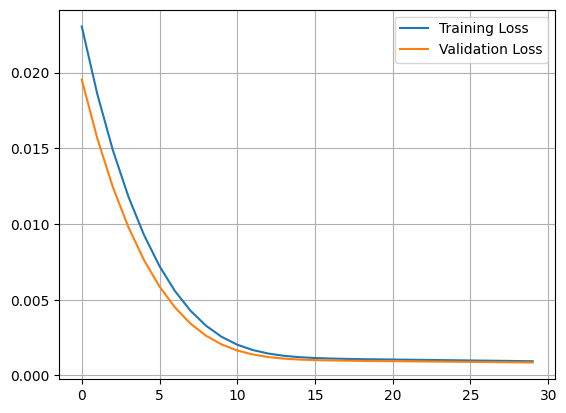

In [153]:
## Plot the loss function

plt.plot(history_m_v .history['loss'], label = 'Training Loss')
plt.plot(history_m_v .history['val_loss'], label = 'Validation Loss')
plt.legend()


In [154]:
## Predict the test data
y_pred = model.predict(x_test)

## Evaluate the model using all the evaluation metrics

print('RMSE:', rmse(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))


455/455 [==============================] - 27s 56ms/step
RMSE: 0.8189928574388762
MAE: 0.8119562521740392
MAPE: 253.91476079256225


In [ ]:
# ## Add the evalutation metrics from all three models to a dataframe

# evaluation_metrics = pd.DataFrame({'Model': ['XGBoost', 'Prophet', 'RNN'],
                            